In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


(a)

Loading and Preprocessing the CIFAR-10 Dataset

We'll start by loading the CIFAR-10 dataset using torchvision.datasets.CIFAR10. We'll separate 10,000 images from the training set to create a validation set. Then, we'll display a random image from each class along with its label

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


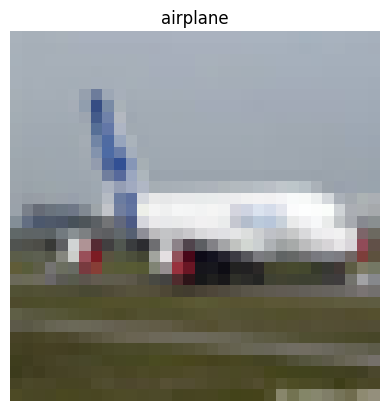

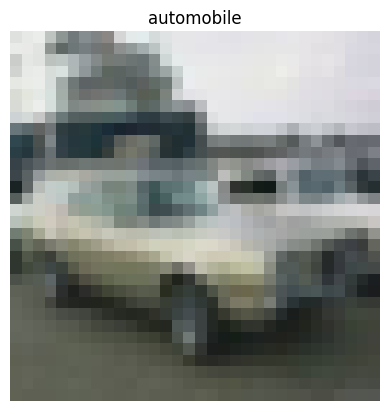

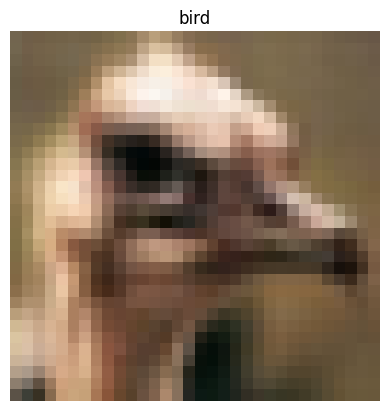

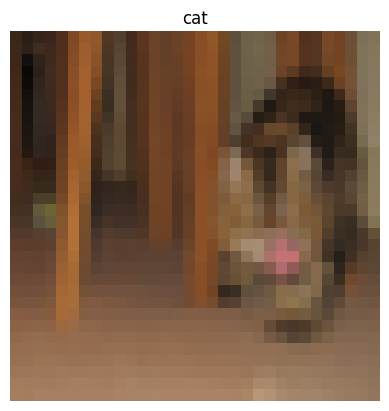

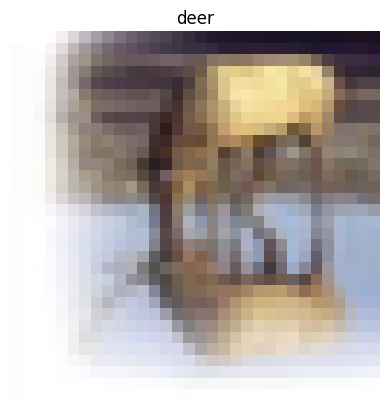

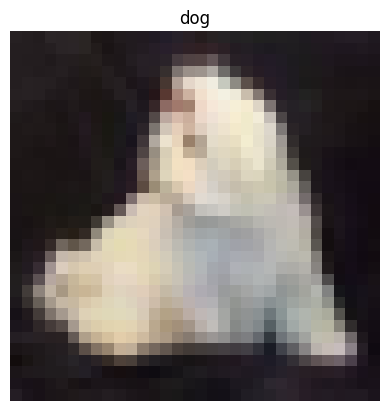

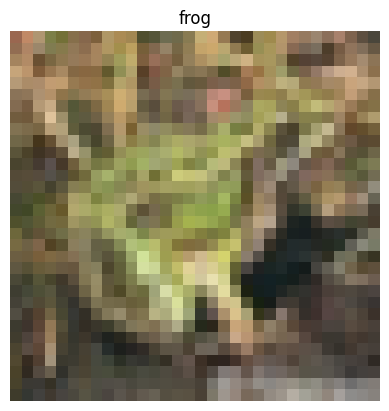

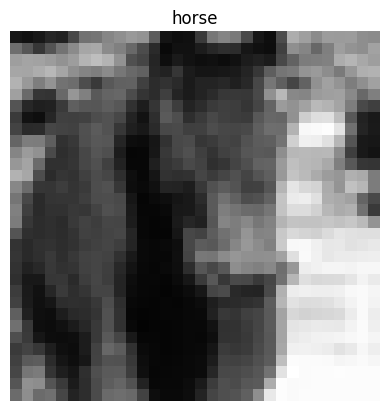

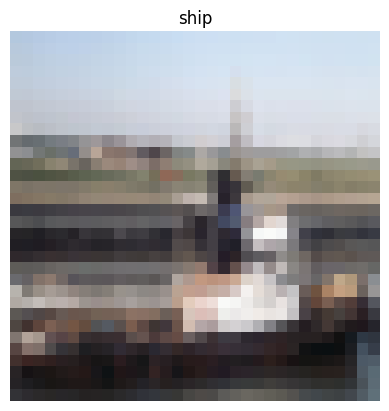

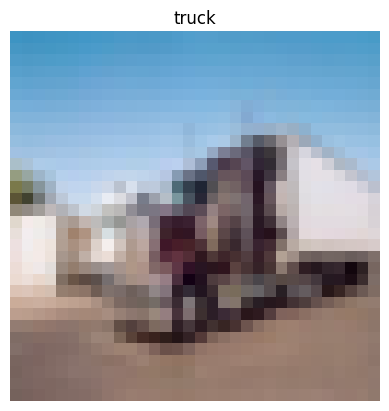

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 training and test datasets
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Separate 10,000 images from the training data for validation
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

# Get class names
classes = train_dataset_full.classes

# Function to display an image
def imshow(img):
#    img = img / 2 + 0.5  # Unnormalize if normalized
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display a random image from each class
for label in range(len(classes)):
    indices = [i for i, (_, target) in enumerate(train_dataset) if target == label]
    random_idx = random.choice(indices)
    image, _ = train_dataset[random_idx]
    plt.title(classes[label])
    imshow(image)

(b)

Training the Baseline Model

We'll use torch.utils.data.DataLoader to create data loaders for batching. Then, we'll train the provided baseline network and report the loss and accuracy on the training and validation datasets.

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
# Define batch size and number of epochs
batch_size = 64
num_epochs = 30

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Baseline model definition
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [6]:
# Initialize the model, loss function, and optimizer
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)

In [7]:
# Training loop for the baseline model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Training phase
    baseline_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    baseline_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = baseline_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')

    # Save the best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(baseline_model.state_dict(), 'best_baseline_model.pth')

Epoch [1/30], Train Loss: 1.6785, Train Acc: 40.53%, Val Loss: 1.5581, Val Acc: 43.75%
Epoch [2/30], Train Loss: 1.4302, Train Acc: 49.68%, Val Loss: 1.3877, Val Acc: 51.09%
Epoch [3/30], Train Loss: 1.3370, Train Acc: 53.31%, Val Loss: 1.3647, Val Acc: 52.48%
Epoch [4/30], Train Loss: 1.2767, Train Acc: 55.95%, Val Loss: 1.3218, Val Acc: 54.15%
Epoch [5/30], Train Loss: 1.2176, Train Acc: 57.84%, Val Loss: 1.2632, Val Acc: 56.16%
Epoch [6/30], Train Loss: 1.1651, Train Acc: 59.63%, Val Loss: 1.2206, Val Acc: 58.06%
Epoch [7/30], Train Loss: 1.1193, Train Acc: 61.38%, Val Loss: 1.2899, Val Acc: 56.42%
Epoch [8/30], Train Loss: 1.0812, Train Acc: 62.47%, Val Loss: 1.2293, Val Acc: 58.64%
Epoch [9/30], Train Loss: 1.0440, Train Acc: 63.78%, Val Loss: 1.2164, Val Acc: 59.14%
Epoch [10/30], Train Loss: 1.0162, Train Acc: 64.99%, Val Loss: 1.1851, Val Acc: 60.26%
Epoch [11/30], Train Loss: 0.9937, Train Acc: 65.83%, Val Loss: 1.1763, Val Acc: 61.17%
Epoch [12/30], Train Loss: 0.9685, Train 

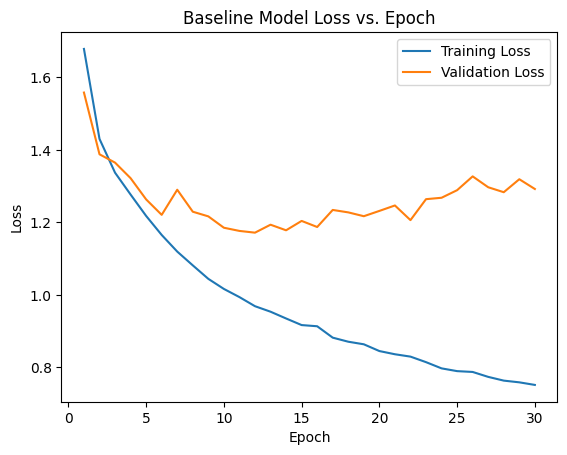

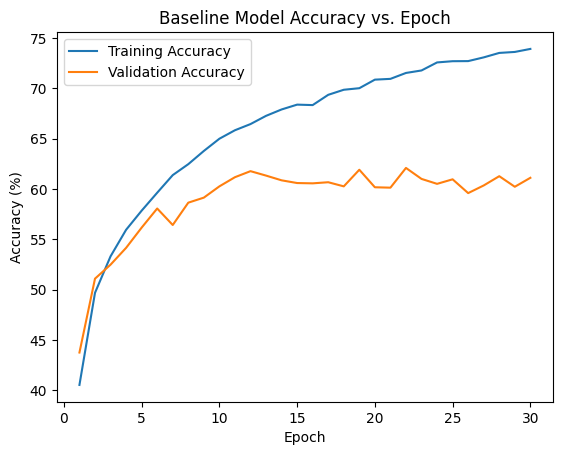

In [8]:
# Plotting loss and accuracy
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline Model Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Baseline Model Accuracy vs. Epoch')
plt.legend()
plt.show()

(c) Upgrading the Baseline Network

In this section, we'll upgrade the baseline network by adding more convolutional layers, pooling layers, and fully connected layers.

In [9]:
# Upgraded model definition
class UpgradedModel(nn.Module):
    def __init__(self):
        super(UpgradedModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [10]:
# Initialize the upgraded model, loss function, and optimizer
upgraded_model = UpgradedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(upgraded_model.parameters(), lr=0.01, momentum=0.9)

In [11]:
# Training loop for the upgraded model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Training phase
    upgraded_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = upgraded_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    upgraded_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = upgraded_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')

    # Save the best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(upgraded_model.state_dict(), 'best_upgraded_model.pth')

Epoch [1/30], Train Loss: 2.1769, Train Acc: 16.86%, Val Loss: 1.9276, Val Acc: 25.35%
Epoch [2/30], Train Loss: 1.7561, Train Acc: 34.49%, Val Loss: 1.7351, Val Acc: 37.47%
Epoch [3/30], Train Loss: 1.4809, Train Acc: 45.73%, Val Loss: 1.3524, Val Acc: 50.80%
Epoch [4/30], Train Loss: 1.2672, Train Acc: 54.43%, Val Loss: 1.2412, Val Acc: 55.82%
Epoch [5/30], Train Loss: 1.1230, Train Acc: 60.11%, Val Loss: 1.1030, Val Acc: 61.45%
Epoch [6/30], Train Loss: 1.0025, Train Acc: 64.69%, Val Loss: 1.0148, Val Acc: 64.31%
Epoch [7/30], Train Loss: 0.9185, Train Acc: 67.77%, Val Loss: 0.9789, Val Acc: 66.11%
Epoch [8/30], Train Loss: 0.8371, Train Acc: 70.47%, Val Loss: 0.9612, Val Acc: 67.37%
Epoch [9/30], Train Loss: 0.7514, Train Acc: 73.67%, Val Loss: 0.9413, Val Acc: 68.63%
Epoch [10/30], Train Loss: 0.6835, Train Acc: 76.02%, Val Loss: 0.9664, Val Acc: 67.96%
Epoch [11/30], Train Loss: 0.6203, Train Acc: 78.19%, Val Loss: 0.9755, Val Acc: 68.28%
Epoch [12/30], Train Loss: 0.5549, Train 

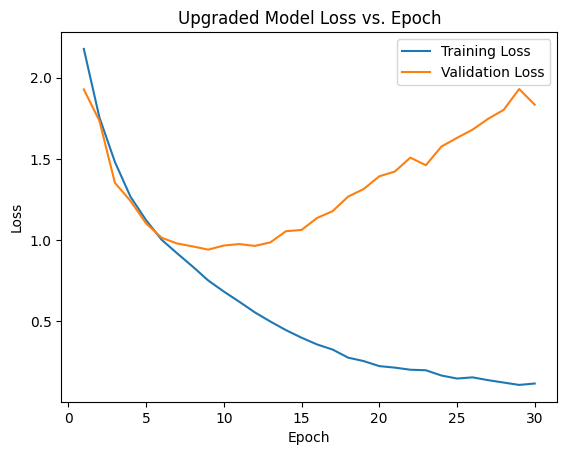

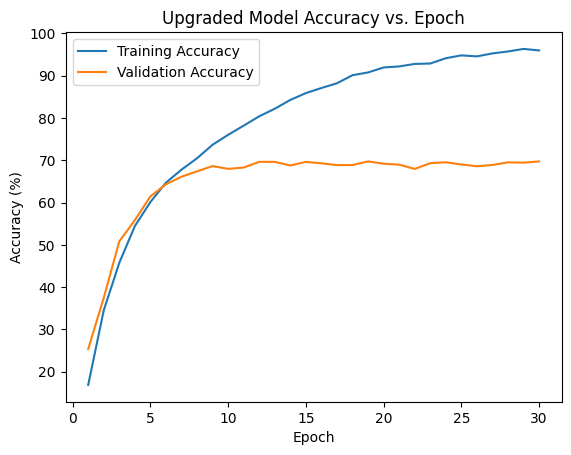

In [12]:
# Plotting loss and accuracy for the upgraded model
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Upgraded Model Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Upgraded Model Accuracy vs. Epoch')
plt.legend()
plt.show()

(d) Adding Batch Normalization



In [13]:
# Upgraded model with Batch Normalization
class UpgradedModelBN(nn.Module):
    def __init__(self):
        super(UpgradedModelBN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [14]:
# Initialize the model with Batch Normalization, loss function, and optimizer
model_bn = UpgradedModelBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)

In [15]:
# Training loop for the model with Batch Normalization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Training phase
    model_bn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_bn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model_bn.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_bn(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')

    # Save the best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model_bn.state_dict(), 'best_model_bn.pth')

Epoch [1/30], Train Loss: 1.3988, Train Acc: 48.96%, Val Loss: 1.5446, Val Acc: 46.71%
Epoch [2/30], Train Loss: 1.0020, Train Acc: 64.44%, Val Loss: 1.0725, Val Acc: 62.87%
Epoch [3/30], Train Loss: 0.8350, Train Acc: 70.41%, Val Loss: 1.0237, Val Acc: 65.18%
Epoch [4/30], Train Loss: 0.7204, Train Acc: 74.69%, Val Loss: 0.8469, Val Acc: 70.61%
Epoch [5/30], Train Loss: 0.6330, Train Acc: 77.91%, Val Loss: 0.9210, Val Acc: 69.23%
Epoch [6/30], Train Loss: 0.5537, Train Acc: 80.49%, Val Loss: 0.8095, Val Acc: 72.82%
Epoch [7/30], Train Loss: 0.4876, Train Acc: 82.93%, Val Loss: 0.9909, Val Acc: 69.37%
Epoch [8/30], Train Loss: 0.4229, Train Acc: 85.41%, Val Loss: 0.8042, Val Acc: 74.22%
Epoch [9/30], Train Loss: 0.3714, Train Acc: 86.83%, Val Loss: 0.8375, Val Acc: 74.26%
Epoch [10/30], Train Loss: 0.3299, Train Acc: 88.17%, Val Loss: 0.8507, Val Acc: 74.19%
Epoch [11/30], Train Loss: 0.2839, Train Acc: 89.94%, Val Loss: 1.0536, Val Acc: 71.28%
Epoch [12/30], Train Loss: 0.2398, Train 

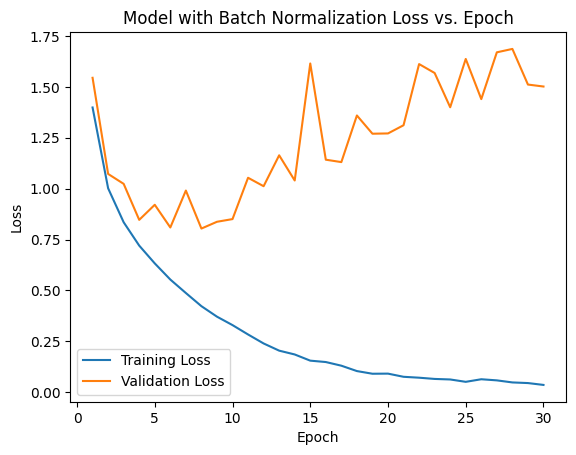

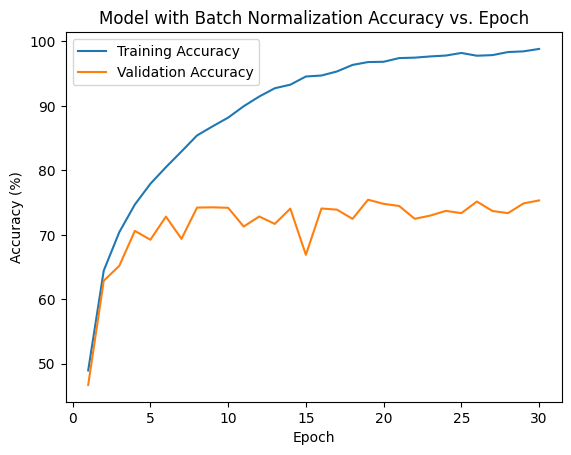

In [16]:
# Plotting loss and accuracy for the model with Batch Normalization
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model with Batch Normalization Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model with Batch Normalization Accuracy vs. Epoch')
plt.legend()
plt.show()

(e) Adding Dropout Layers



In [17]:
# Model with Batch Normalization and Dropout
class UpgradedModelBNDropout(nn.Module):
    def __init__(self):
        super(UpgradedModelBNDropout, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [18]:
# Initialize the model with Batch Normalization and Dropout, loss function, and optimizer
model_bn_dropout = UpgradedModelBNDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn_dropout.parameters(), lr=0.01, momentum=0.9)

In [19]:
# Training loop for the model with Batch Normalization and Dropout
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Training phase
    model_bn_dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_bn_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model_bn_dropout.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_bn_dropout(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')

    # Save the best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model_bn_dropout.state_dict(), 'best_model_bn_dropout.pth')

Epoch [1/30], Train Loss: 1.6421, Train Acc: 38.72%, Val Loss: 1.2912, Val Acc: 51.93%
Epoch [2/30], Train Loss: 1.2702, Train Acc: 54.95%, Val Loss: 1.1667, Val Acc: 59.17%
Epoch [3/30], Train Loss: 1.1124, Train Acc: 61.17%, Val Loss: 1.0250, Val Acc: 64.07%
Epoch [4/30], Train Loss: 0.9883, Train Acc: 65.95%, Val Loss: 1.2460, Val Acc: 59.75%
Epoch [5/30], Train Loss: 0.9017, Train Acc: 69.13%, Val Loss: 0.9566, Val Acc: 67.33%
Epoch [6/30], Train Loss: 0.8307, Train Acc: 71.81%, Val Loss: 0.9114, Val Acc: 69.09%
Epoch [7/30], Train Loss: 0.7681, Train Acc: 73.72%, Val Loss: 0.9215, Val Acc: 69.73%
Epoch [8/30], Train Loss: 0.7069, Train Acc: 76.17%, Val Loss: 0.8804, Val Acc: 70.36%
Epoch [9/30], Train Loss: 0.6619, Train Acc: 77.67%, Val Loss: 0.8618, Val Acc: 71.97%
Epoch [10/30], Train Loss: 0.6092, Train Acc: 79.38%, Val Loss: 1.0116, Val Acc: 67.70%
Epoch [11/30], Train Loss: 0.5730, Train Acc: 80.57%, Val Loss: 1.0581, Val Acc: 68.30%
Epoch [12/30], Train Loss: 0.5336, Train 

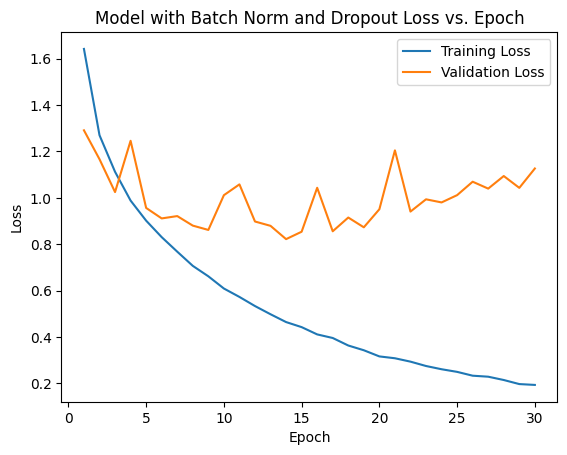

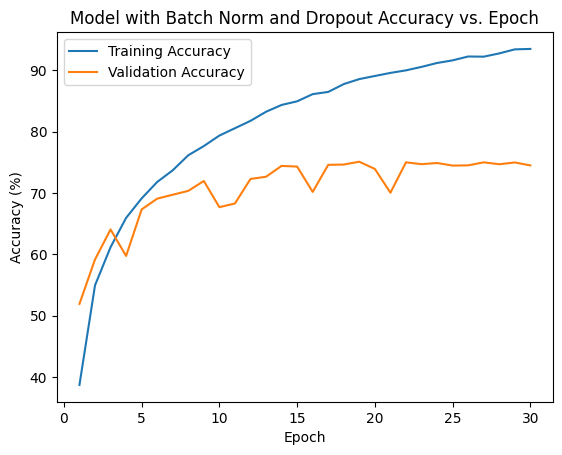

In [20]:
# Plotting loss and accuracy for the model with Batch Normalization and Dropout
epochs = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model with Batch Norm and Dropout Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model with Batch Norm and Dropout Accuracy vs. Epoch')
plt.legend()
plt.show()

(f) Evaluating the Best Models on the Test Dataset



In [21]:
# Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [22]:
# Create a test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [23]:
# Function to evaluate a model on the test data
def evaluate_model(model_class, model_path, model_name):
    # Initialize the model and load the saved weights
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

<ipython-input-23-186f4eed150b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Baseline Model Test Accuracy: 61.12%


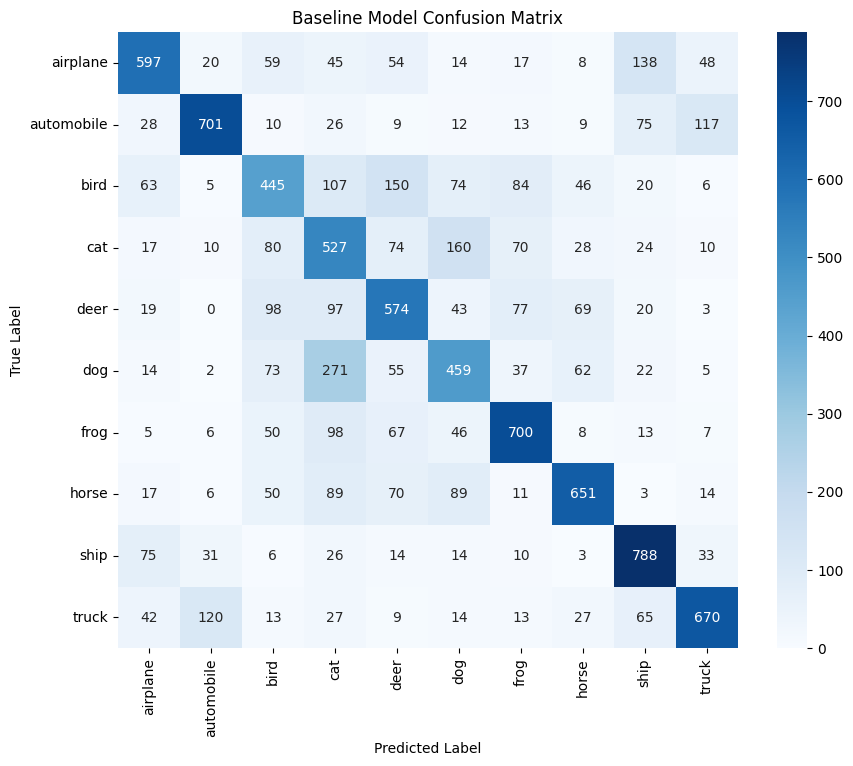

In [24]:
# Evaluate the Baseline Model
evaluate_model(BaselineModel, 'best_baseline_model.pth', 'Baseline Model')

<ipython-input-23-186f4eed150b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Upgraded Model Test Accuracy: 68.66%


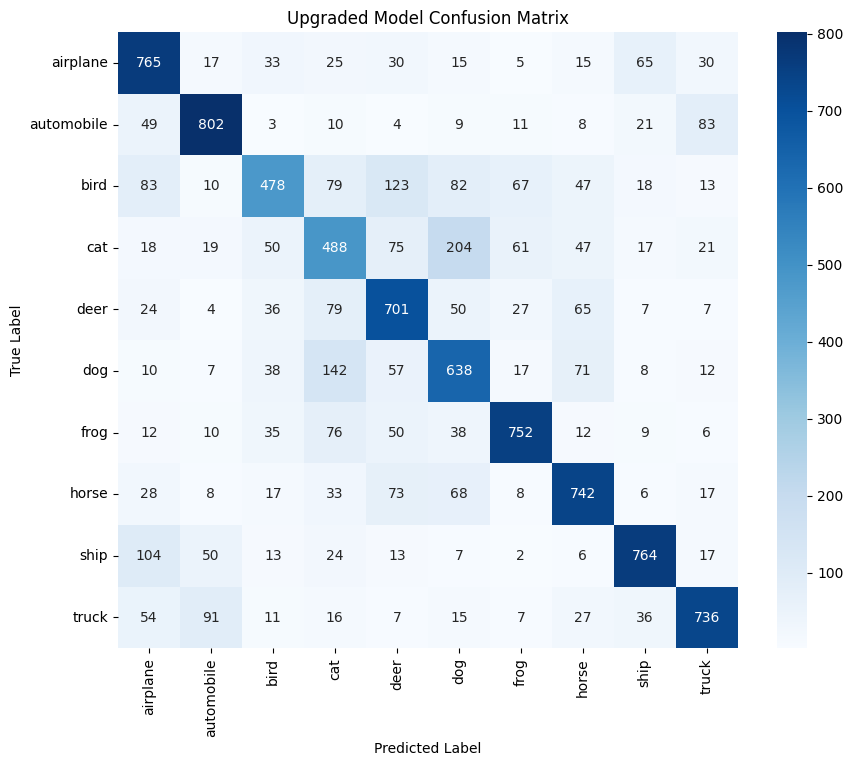

In [25]:
# Evaluate the Upgraded Model
evaluate_model(UpgradedModel, 'best_upgraded_model.pth', 'Upgraded Model')

<ipython-input-23-186f4eed150b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model with Batch Norm Test Accuracy: 75.28%


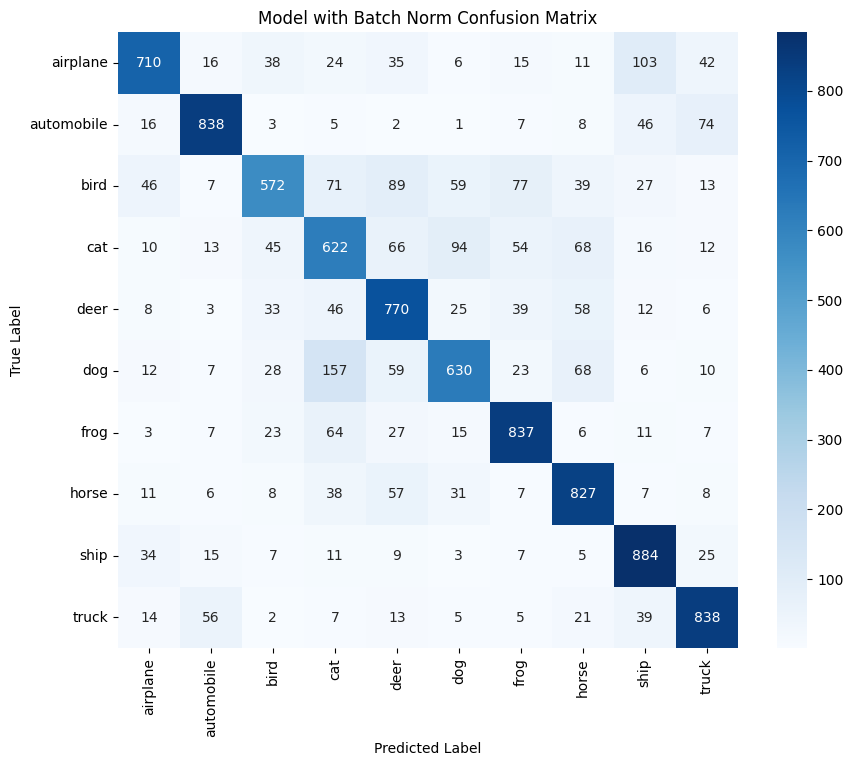

In [26]:
# Evaluate the Model with Batch Normalization
evaluate_model(UpgradedModelBN, 'best_model_bn.pth', 'Model with Batch Norm')

<ipython-input-23-186f4eed150b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model with Batch Norm and Dropout Test Accuracy: 75.22%


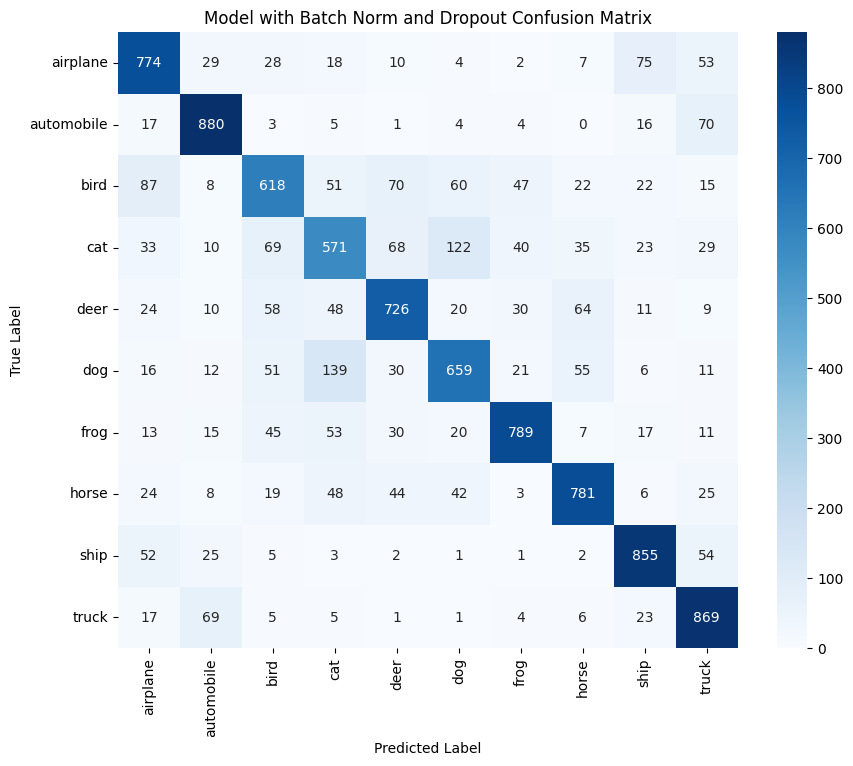

In [27]:
# Evaluate the Model with Batch Normalization and Dropout
evaluate_model(UpgradedModelBNDropout, 'best_model_bn_dropout.pth', 'Model with Batch Norm and Dropout')